**Start with `pip install -r requirements_issue_375.txt`**

Will also need to create a `config/nmdc_mongo_db.yaml` file follwoing this pattern

```
mongo_nmdc_password:
  "<SECRET>"
```

- no environmental metadata yet
- not sure how to model additional authors
- still working on blue

TODO: illustrate use of annotator API

In [1]:
import pandas as pd

# use openpyxl for reading xlsx spreadsheet
# or  https://medium.com/analytics-vidhya/how-to-read-and-write-data-to-google-spreadsheet-using-python-ebf54d51a72c
# https://github.com/ontodev/cogs for google sheets? may assume single tab
import json

# from math import isnan
# for sqrt
import math
import re

# from collections import Counter
import uuid

from Bio import Entrez
import xmltodict

import warnings

from pymongo import MongoClient
from pprint import pprint

import yaml

# import linkml_runtime

# from linkml.utils.rawloader import load_raw_schema
from linkml.utils.schemaloader import SchemaLoader

# find relevant portions of MenuTerms
from sklearn.cluster import OPTICS
import numpy as np

# cluster diasnostics
import matplotlib.pyplot as plt

In [2]:
# import bmt

# tk = bmt.Toolkit("../../nmdc-schema/src/schema/nmdc.yaml")

# attrib_descendants = tk.get_descendants(name='attribute')
# attrib_descendants.sort()

# print(len(attrib_descendants))

# attrib_descendants

# # 614 out of the 699 slots in mixs are descendants of 'attribute'
##  filtering doens't seem worth it here

In [3]:
with open("../config/nmdc_mongo_db.yaml") as conf_file:
    conf_data = yaml.load(conf_file, Loader=yaml.Loader)

In [4]:
# conf_data["password"]

In [5]:
# mongodb://[username:password@]host1[:port1][,...hostN[:portN]][/[defaultauthdb][?options]]

mongo_conn_str = (
    "mongodb://mam:"
    + conf_data["mongo_nmdc_password"]
    + "@mongo-ext.nmdc-runtime-dev.polyneme.xyz"
)
# mongo_conn_str = "mongodb://localhost"

client = MongoClient(mongo_conn_str)

In [6]:
def remove_nans_from_dict(inp_dict):
    clean_dict = {k: v for k, v in inp_dict.items() if v == v}
    return clean_dict

In [7]:
def merge_j_on_index(left_j, right_j):
    left_copy = left_j.copy()
    for i in range(len(green_nmdc)):
        left_copy[i] = remove_nans_from_dict(left_copy[i])
        right_temp = right_j[i]
        right_temp = remove_nans_from_dict(right_temp)
        left_copy[i].update(right_temp)
    return left_copy

In [8]:
def make_searchable_sheet(df):
    zipped_tmts = dict(zip(df.columns, range(len(df.columns))))
    searchable = df.rename(columns=zipped_tmts).stack()
    return searchable


def search_get_coords(searchable, search_string):
    match_coords_list = searchable[(searchable == search_string)].index.tolist()
    return match_coords_list


def euc_pair_dist(point1, point2):
    x_dist = point2[0] - point1[0]
    xds = x_dist ** 2
    y_dist = point2[1] - point1[1]
    yds = y_dist ** 2
    dist_sum = xds + yds
    dist_root = math.sqrt(dist_sum)
    return dist_root


def find_first_closest(xy_tuple_list, origin):
    dists = []
    for xy_tuple in xy_tuple_list:
        current_dist = euc_pair_dist(origin, xy_tuple)
        dists.append(current_dist)
    val, idx = min((val, idx) for (idx, val) in enumerate(dists))
    return xy_tuple_list[idx]


# add rowcount parameter?
# doesn't seem necessary
# the whole point is that we're determinign the appropriate row count
def get_from_find_to_end(df, start, colcount):
    df_row_count = len(df.index)
    found_to_end = df.iloc[
        start[0] : (df_row_count - 1), start[1] : (start[1] + (colcount))
    ]
    found_to_end = found_to_end.reset_index(drop=True)
    return found_to_end


# assuming we should search for nas in first column
def get_from_start_to_na(df):
    df_isna = df.isna()
    df_isna_loc = df_isna.idxmax().values[0]
    # could this ever be larger than one element?
    df_to_na = df[0:df_isna_loc]
    return df_to_na


def colnames_from_rowvals(df, row):
    df.columns = df.iloc[row].values
    return df


def colnames_from_rowvals(df, row):
    df.columns = df.iloc[row].values
    return df

In [9]:
# add removal of NaNs?
def remove_rows_matching_list(
    df, column, exclusion_list, remove_nans=True, remove_header_val=True
):
    if remove_header_val:
        col_header = df.columns[column]
        exclusion_list.append(col_header)
    extract = df.iloc[:, column]
    goodflag = ~extract.isin(exclusion_list)
    keepers = df[goodflag]
    if remove_nans:
        keepers.dropna(axis=0, how="any", inplace=True)
    keepers.reset_index(drop=True, inplace=True)
    return keepers

In [10]:
def get_optics_coord_frame(df, current_search_string):
    # may have already been assembled elsewhere ... factor back out?
    searchable_menu = make_searchable_sheet(df)
    tx_coords = search_get_coords(searchable_menu, current_search_string)
    tx_coord_frame = pd.DataFrame(tx_coords, columns=["y", "x"])
    tx_custers = OPTICS(min_samples=2).fit(tx_coords)
    tx_per_coord_labels = tx_custers.labels_
    tx_coord_frame["cluster"] = tx_per_coord_labels
    return tx_coord_frame

In [11]:
def get_data_from_extended_cluster_coords(
    data_df, cluster_coords_df, largest_index, additional_columns=0
):
    temp = cluster_coords_df[cluster_coords_df["cluster"] == largest_index]
    xmin = temp["x"].min()
    xmax = temp["x"].max()
    ymin = temp["y"].min()
    ymax = temp["y"].max()

    additional_columns = 3
    extended_x_max = xmax + additional_columns
    data_from_extended_cluster_coords = data_df.loc[ymin:ymax, xmin:extended_x_max]
    return data_from_extended_cluster_coords

In [12]:
warnings.filterwarnings("ignore", category=UserWarning)

In [13]:
# could use entrez to retrieve addtional project details based on NCBI IDs
# initialize some default parameters
Entrez.email = "MAM@lbl.gov"  # provide your email address

# db = 'bioproject'
# db = "dbvar"

paramEutils = {"usehistory": "Y"}  # Use Entrez search history to cache results

In [14]:
# list Entrez databases
entrez_databases = Entrez.read(Entrez.einfo())
# entrez_databases

## Provenance

saved https://docs.google.com/spreadsheets/d/1GZayIFIrY2jdoxRIpk9KDTBLiE71VVtb7YAd5ZSYGR0/edit#gid=0
to `input/Example-Soil_NMDC_SampleMetadata.xlsx` on 2021-07-13

Also 
- `Example-Soil_NMDC_SampleMetadata_202107201146.xlsx`


In [15]:
template_file = "../input/Example-Soil_NMDC_SampleMetadata_202107201146.xlsx"
mixs_spreadsheet_url = "https://github.com/GenomicsStandardsConsortium/mixs-legacy/blob/master/mixs5/mixs_v5.xlsx?raw=true"

# could also get MIxS knoweldge from NMDC schema... have been menaing to parse that anyway

In [16]:
template_frame_structure = pd.read_excel(template_file, sheet_name=None)
template_sheet_names = template_frame_structure.keys()
list(template_sheet_names)

['ReadMe',
 'ProjectInformation',
 'AssociatedResearchers',
 'Metadata',
 'EnvironmentalMetadata',
 'EcosystemTerms',
 'MenuTerms']

> /Users/MAM/Documents/gitrepos/nmdc-metadata/venv/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
  
https://docs.python.org/3/library/warnings.html

The "Metadata" sheet in the NMDC Sample Metadata template has four header rows and color coded blocks of columns. The green and red sections have fixed columns. Here, the second though fourth rows provide elaboration on the expected content. _Remember, Pandas interprets the very first row as a dataframe's headers by default._

There's no sample data in the `EnvironmentalMetadata` tab yet, but that will need to be parsed, too.


In [17]:
header_rows = 4

# column/color block realtions for `Metadata` tab
# "Sample Identification"
green_id_col = ["ID"]
additional_green_col_names = [
    "sample_name",
    "investigation_type",
    "package",
    "source_mat_ID",
]
green_cols = green_id_col + additional_green_col_names

# "Required for all samples"
red_col_names = [
    "growth_facil",
    "geo_loc_name",
    "lat_lon",
    "collection_date",
    "samp_mat_process",
    "store_cond",
    "samp_store_temp",
    "samp_size",
    "env_broad_scale",
    "env_local_scale",
    "env_medium",
    "gold_ecosystem",
    "microbiome_taxonomy",
]

## `ProjectInformation` tab

The project data are are organized in a single column

Transforming them here to a single-row dataframe, based on prior experience with metadata tab

In [18]:
template_projinf_frame = pd.read_excel(template_file, sheet_name="ProjectInformation")
template_projinf_frame = template_projinf_frame.transpose()
template_projinf_frame.columns = template_projinf_frame.iloc[0]
template_projinf_frame = template_projinf_frame.reset_index(drop=True)

# drop field names once they've become column names
template_projinf_frame = template_projinf_frame.drop(0)

# # drop blank left-most column
column_numbers = [
    x for x in range(template_projinf_frame.shape[1])
]  # list of columns' integer indices
column_numbers.remove(0)  # removing column integer index 0
template_projinf_frame = template_projinf_frame.iloc[
    :, column_numbers
]  # return all columns except the 0th column

template_projinf_frame

Study Metadata,Project/Study Name,Principal Investigator Name,Principal Investigator Email,Principal Investigator ORCiD,LinkOut Webpage,Project/Study Description,Associated Publications,Dataset DOIs,Type of samples,Alternative Names,EMSL Proposal/Study Number,GOLD Study ID,JGI Proposal ID,Umbrella Bio Project Name,Umbrella Bio Project ID
1,"""Soil microbial response to elevated temperatu...",Montana Smith,montana.smith@pnnl.gov,0000-0002-8683-0050,https://microbiomedata.org/ | https://github.c...,NaN,https://doi.org/10.1016/j.soilbio.2019.107561 ...,https://doi.org/10.25585/1487765,soil,NaN,EMSL:29728,GOLD:Gs01971387,JGI:1781,NCBI Accession: PRJNA594403,NCBI ID: 594403


In [19]:
proj_row_list = template_projinf_frame.to_dict("records")
proj_row_list
proj_obj = proj_row_list[0]
pprint(proj_obj)

{'Alternative Names': nan,
 'Associated Publications': 'https://doi.org/10.1016/j.soilbio.2019.107561 | '
                            'Keiser, Ashley D., et al. "Peatland microbial '
                            'community response to altered climate tempered by '
                            'nutrient availability." Soil Biology and '
                            'Biochemistry 137 (2019): 107561.',
 'Dataset DOIs': 'https://doi.org/10.25585/1487765',
 'EMSL Proposal/Study Number': 'EMSL:29728',
 'GOLD Study ID': 'GOLD:Gs01971387',
 'JGI Proposal ID': 'JGI:1781',
 'LinkOut Webpage': 'https://microbiomedata.org/ | '
                    'https://github.com/microbiomedata',
 'Principal Investigator Email': 'montana.smith@pnnl.gov',
 'Principal Investigator Name': 'Montana Smith',
 'Principal Investigator ORCiD': '0000-0002-8683-0050',
 'Project/Study Description': nan,
 'Project/Study Name': '"Soil microbial response to elevated temperatures and '
                       'increased carbon ava

### Example of obtaining project details from NCBI with Entrez

Reddy: no API for GOLD and JGI?
But the values may be in NCBI?
What about EMSL or

In [20]:
# value of having both BioProject ID and accession "name"?
proj_bioproj_id = proj_obj["Umbrella Bio Project ID"]
bioproj_rhs = re.sub("^.*: *", "", proj_bioproj_id)
# bioproj_rhs

In [21]:
handle = Entrez.esummary(db="bioproject", id=bioproj_rhs)
record = Entrez.read(handle)
handle.close()
# record

bioproj_record_json = json.dumps(record, indent=4, sort_keys=False, default=str)
# print(bioproj_record_json)

---

### Get NMDC classes

In [22]:
# nmdc_schema_resolved = load_raw_schema("../../nmdc-schema/src/schema/nmdc.yaml")

nmdc_schema_resolved = SchemaLoader("../../nmdc-schema/src/schema/nmdc.yaml").resolve()

# for key in nmdc_schema_resolved.classes.keys():
#     print(key)

nmdc_resolved_classes = list(nmdc_schema_resolved.classes.keys())
nmdc_resolved_classes.sort()

# nmdc_resolved_classes

Unrecognized prefix: rdfs
Unrecognized prefix: UniProtKB
Unrecognized prefix: gtpo
Unrecognized prefix: COG
Unrecognized prefix: MetaCyc
Unrecognized prefix: EC
Unrecognized prefix: MetaNetX
Unrecognized prefix: RetroRules


### Get NMDC schema `study` slots
_Included inherited slots_

This and more will all be reconciled below

In [23]:
study_slots = nmdc_schema_resolved.classes["study"].slots
study_slots.sort()
# study_slots

### Get `ProjectInformation` fields from `Example-Soil_NMDC_SampleMetadata`

Might have to use APIs like from Entrez to look up details for some of those IDs?

In [24]:
project_fields = list(template_projinf_frame.columns)
project_fields.sort()
# project_fields

### Get `study` data from mongodb

In [25]:
db = client.nmdc
coll = db["study_set"]

any_study = coll.find_one({"type": "nmdc:Study"})
pprint(any_study)

{'_id': ObjectId('60e840cbe9822b255ad93845'),
 'description': 'This study is part of the Plant-Microbe Interfaces Science '
                'Focus Area, which aims to gain a deeper understanding of the '
                'diversity and functioning of mutually beneficial interactions '
                'between plants and microbes in the rhizosphere. Ongoing '
                'efforts focus on characterizing and interpreting such '
                'interfaces using systems comprising plants and microbes, in '
                'particular the poplar tree (Populus) and its microbial '
                'community in the context of favorable plant microbe '
                'interactions.',
 'doi': {'has_raw_value': 'https://doi.org/10.25585/1488096'},
 'ecosystem': 'Host-associated',
 'ecosystem_category': 'Plants',
 'ecosystem_subtype': 'Unclassified',
 'ecosystem_type': 'Unclassified',
 'id': 'gold:Gs0103573',
 'name': 'Populus root and rhizosphere microbial communities from Tennessee, '
    

In [26]:
all_studies = list(coll.find({}))

study_frame = pd.DataFrame(all_studies)

study_frame

,_id,id,name,description,ecosystem,ecosystem_category,ecosystem_type,ecosystem_subtype,specific_ecosystem,principal_investigator,type,websites,title,doi,publications
0,60e840cbe9822b255ad93845,gold:Gs0103573,Populus root and rhizosphere microbial communi...,This study is part of the Plant-Microbe Interf...,Host-associated,Plants,Unclassified,Unclassified,Unclassified,{'has_raw_value': 'Dale Pelletier'},nmdc:Study,[https://pmiweb.ornl.gov/pmi-project-aims/],Defining the functional diversity of the Popul...,{'has_raw_value': 'https://doi.org/10.25585/14...,[https://doi.org/10.1128/mSystems.00045-18]
1,60e840cbe9822b255ad93846,gold:Gs0110138,"Peatland microbial communities from Minnesota,...",This study is part of the Spruce and Peatland ...,Environmental,Aquatic,Freshwater,Wetlands,Unclassified,{'has_raw_value': 'Erik Lilleskov'},nmdc:Study,[https://mnspruce.ornl.gov/project/overview],"Fungal, bacterial, and archaeal communities me...",{'has_raw_value': 'https://doi.org/10.25585/14...,NaN
2,60e840cbe9822b255ad93847,gold:Gs0114663,Riverbed sediment microbial communities from t...,"This research project, led by James Stegen at ...",Environmental,Aquatic,Freshwater,River,Sediment,"{'has_raw_value': 'James Stegen', 'profile_ima...",nmdc:Study,NaN,NaN,{'has_raw_value': 'https://doi.org/10.25585/14...,[https://doi.org/10.1371/journal.pone.0228165]
3,60e840cbe9822b255ad93848,gold:Gs0114675,Deep subsurface shale carbon reservoir microbi...,This project aims to improve the understanding...,Environmental,Terrestrial,Deep subsurface,Unclassified,Unclassified,"{'has_raw_value': 'Kelly Wrighton', 'profile_i...",nmdc:Study,NaN,NaN,{'has_raw_value': 'https://doi.org/10.25585/14...,NaN
4,60e840cbe9822b255ad93849,gold:Gs0128850,Lab enrichment of tropical soil microbial comm...,This study is part of the Microbes Persist: Sy...,Environmental,Terrestrial,Soil,Unclassified,Forest Soil,"{'has_raw_value': 'Jennifer Pett-Ridge', 'prof...",nmdc:Study,[https://sc-programs.llnl.gov/biological-and-e...,Microbial Carbon Transformations in Wet Tropic...,{'has_raw_value': 'https://doi.org/10.25585/14...,NaN
5,60e840cbe9822b255ad9384a,gold:Gs0135149,Bulk soil microbial communities from the East ...,This research project aimed to understand how ...,Environmental,Terrestrial,Soil,Meadow,Bulk soil,"{'has_raw_value': 'Eoin Brodie', 'profile_imag...",nmdc:Study,NaN,NaN,{'has_raw_value': 'https://doi.org/10.25585/14...,[https://doi.org/10.21952/WTR/1573029]
6,60e840cbe9822b255ad9384c,gold:Gs0154044,Bulk and rhizosphere soil microbial communitie...,The goal of this Bio-Scales Pilot Project stud...,Environmental,Terrestrial,Soil,Unclassified,Unclassified,"{'has_raw_value': 'Mitchel J. Doktycz', 'profi...",nmdc:Study,[https://www.ornl.gov/staff-profile/mitchel-j-...,Bio-Scales: Defining plant gene function and i...,{'has_raw_value': 'https://doi.org/10.46936/10...,NaN


In [27]:
study_cols = list(study_frame.columns)
study_cols.sort()
study_cols

['_id',
 'description',
 'doi',
 'ecosystem',
 'ecosystem_category',
 'ecosystem_subtype',
 'ecosystem_type',
 'id',
 'name',
 'principal_investigator',
 'publications',
 'specific_ecosystem',
 'title',
 'type',
 'websites']

In [28]:
study_frame.isna().sum()

_id                       0
id                        0
name                      0
description               0
ecosystem                 0
ecosystem_category        0
ecosystem_type            0
ecosystem_subtype         0
specific_ecosystem        0
principal_investigator    0
type                      0
websites                  3
title                     3
doi                       0
publications              4
dtype: int64

### Matches between template and schema

| NMDC schema study slots  | ProjectInformation fields from Example-Soil_NMDC_SampleMetadata   |
|:-------------------------|:------------------------------------------------------------------|
| alternative names        | Alternative Names                                                 |
| description              | Project/Study Description                                         |
| doi                      | Dataset DOIs                                                      |
| name                     | Project/Study Name                                                |
| principal investigator   | Principal Investigator ORCiD, Principal Investigator ORCiD        |
| publications             | Associated Publications                                           |
| type                     | constant 'study'                                                  |
| websites                 | LinkOut Webpage                                                   |


### How many of these ID-like fields do we expect to be filled? 

0? 1? Multiple? All?

How to prioritize picking just one?

- EMSL Proposal/Study Number
- GOLD Study ID
- JGI Proposal ID
- Umbrella Bio Project ID

### Utilized but unaccounted-for slots
Ie. these slots have at least some data in the current mongodb. There don't seem to be any corresponding ProjectInformation fields 

- id (see above)
- title
- All study-wide ecosystem terms
    - ecosystem
    - ecosystem_category
    - ecosystem_subtype
    - ecosystem_type
    - specific_ecosystem
    
### Non-utilized and unaccounted-for slots    
    
- abstract
- alternate identifiers
- alternative descriptions
- alternative titles
- objective
- study-wide ecosystem slots

```
title OPT
Description: A name given to the entity that differs from the name/label programatically assigned to it. For example, when extracting study information for GOLD, the GOLD system has assigned a name/label. However, for display purposes, we may also wish the capture the title of the proposal that was used to fund the study.
Range: String
```

### Unaccounted template fields

- Principal Investigator Email
    - see https://microbiomedata.github.io/nmdc-schema/PersonValue.html
- Type of samples
- Umbrella Bio Project Name



In [29]:
proj_uuid = uuid.uuid4().hex
proj_nmdc = {
    # which ID to use?
    # using a UUID as a placeholder
    "id": proj_uuid,
    "name": proj_obj["Project/Study Name"],
    "description": proj_obj["Project/Study Description"],
    "principal_investigator": {
        "has raw value": proj_obj["Principal Investigator Name"],
        "orcid": proj_obj["Principal Investigator ORCiD"],
    },
    "type": "Study",
    "websites": re.split(" *\| *", proj_obj["LinkOut Webpage"]),
    "publications": re.split(" *\| *", proj_obj["Associated Publications"]),
    # does the template expect multiple DOIs?
    "doi": {
        "has raw value": proj_obj["Dataset DOIs"],
    },
}
pprint(proj_nmdc)

{'description': nan,
 'doi': {'has raw value': 'https://doi.org/10.25585/1487765'},
 'id': '5c2b5eff69b8453babd69f85b379ea40',
 'name': '"Soil microbial response to elevated temperatures and increased '
         'carbon availability"',
 'principal_investigator': {'has raw value': 'Montana Smith',
                            'orcid': '0000-0002-8683-0050'},
 'publications': ['https://doi.org/10.1016/j.soilbio.2019.107561',
                  'Keiser, Ashley D., et al. "Peatland microbial community '
                  'response to altered climate tempered by nutrient '
                  'availability." Soil Biology and Biochemistry 137 (2019): '
                  '107561.'],
 'type': 'Study',
 'websites': ['https://microbiomedata.org/',
              'https://github.com/microbiomedata']}


## `AssociatedResearchers` tab

In [30]:
template_assocs_frame = pd.read_excel(template_file, sheet_name="AssociatedResearchers")
template_assocs_frame

,Name,email,ORCiD,Role- CRediT
0,Pajau Vangay,pvangay@lbl.gov,0000-0002-9231-0692,Project administration


## `Metadata` tab

In [31]:
# template_sheet_names

In [32]:
template_metadata_frame = pd.read_excel(template_file, sheet_name="Metadata")

In [33]:
template_metadata_headers = template_metadata_frame.loc[
    0 : (header_rows - 2),
]
template_metadata_headers

,ID,sample_name,investigation_type,package,source_mat_ID,growth_facil,geo_loc_name,lat_lon,collection_date,samp_mat_process,...,treatment.3,samp_collect_device,size_fract,select,select.1,select.2,select.3,select.4,select.5,select.6
0,"Universally unique ID (ex: IGSN, UUID)",Sample name/Laboratory ID,Analysis/ Data Type,Sample Type,Source Material ID,Growth Facility,Geographical Location Name,latitude;longitude,Collection Date and Time,sample material processing,...,watering_regm,slide_hammer_core,sieving,select,select,select,select,select,select,select
1,Field REQUIRED for ALL sample submission. Opti...,Human readable ID. This is the ID that will be...,This field is constrained to contain only a se...,This field contains the type of sample type as...,A unique identifier assigned to an original ma...,Type of facility where the sample was collecte...,Detailed geographic location of sampling site,The geographical origin of the sample as defin...,"The time of sampling, either as an instance (s...",Any processing applied to the sample during or...,...,treatment- watering regimen/schedule,sample collection device-slide hammer corer,size fraction-sieve size,,,,,,,
2,{text},{text},{text};{text};{text},drop down selection,NaN,drop down selection,{text},{float};{float},{YYYY-MM-DDTHH:MM:SS} or {YYYY-MM-DD},{text},...,{float} {unit};{Rn/start_time/end_time/duration},{text},{value}{units},,,,,,,


In [34]:
template_metadata_headers_cols = pd.Series(template_metadata_headers.columns)

In [35]:
# discard any column whose Pandas header starts with "select" possibly followed by a period and some digits
# these go up to column AH now (#34 when starting at 1)
# could that increase?

select_flag = template_metadata_headers_cols.str.match(
    "^select(\\.\\d+)?$", case=True, flags=0, na=None
)
select_cols = template_metadata_headers_cols[select_flag]

In [36]:
# select_cols

In [37]:
# all column names except for those that start with "select..."
keeper_cols = template_metadata_headers_cols[~select_flag]
# keeper_cols

In [38]:
template_metadata_content = template_metadata_frame.loc[
    3:,
]
template_metadata_content = template_metadata_content[list(keeper_cols)]

### Assumptions:
- lowercased column header of select.* means no data?
- **also check for non-NAs?**

In [39]:
# make sure no sample metadata slipped in here

select_content = template_metadata_frame[select_cols]
select_content

,select,select.1,select.2,select.3,select.4,select.5,select.6
0,select,select,select,select,select,select,select
1,,,,,,,
2,,,,,,,
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Be prepared to check template assumptions against MIxS expectations

In [40]:
template_menu_terms = pd.read_excel(
    template_file, sheet_name="MenuTerms", nrows=1000, header=None
)

In [41]:
# template_menu_terms.shape

In [42]:
# find the spot in the MenuTerms tab where "investigation_type" is mentioned
searchable_menu = make_searchable_sheet(template_menu_terms)

In [43]:
current_search_string = "Look Up Options"
loo_coords = search_get_coords(searchable_menu, current_search_string)
closest_found = find_first_closest(loo_coords, (0, 0))
found_to_end = get_from_find_to_end(template_menu_terms, closest_found, colcount=2)
first_loo_found_to_na = get_from_start_to_na(found_to_end)
# first_loo_found_to_na

# the source sheet for this extract was intentionally parsed with header=None
# is there any row that could serve as the header?
# remove rows where column "0" is "Look Up Options", "Sample_category", "select"
# and column "1" is NaN, "Variable", "select"

In [44]:
package_to_blue_col = colnames_from_rowvals(first_loo_found_to_na, 1)
# package_to_blue_col

In [45]:
package_to_blue_col = remove_rows_matching_list(
    package_to_blue_col, 1, ["Variable", "select"]
)
# A value is trying to be set on a copy of a slice from a DataFrame

/Users/MAM/Documents/gitrepos/nmdc-metadata/venv/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


### Which column (groups) go with which packages?
_According to the template_

In [46]:
package_to_blue_col.sort_values(by=["Sample_category", "Variable"])

,Sample_category,Variable
10,plant_associated,elev
13,plant_associated,host_common_name
14,plant_associated,host_taxid
11,plant_associated,plant_struc
12,plant_associated,treatment
6,sediment,depth
5,sediment,elev
8,sediment,samp_collect_device
9,sediment,size_fract
7,sediment,treatment


In [47]:
current_search_string = "investigation_type"
inv_type_coords = search_get_coords(searchable_menu, current_search_string)
closest_found = find_first_closest(inv_type_coords, (0, 0))
closest_found

(207, 0)

In [48]:
found_to_end = get_from_find_to_end(template_menu_terms, closest_found, colcount=1)
investigation_types = get_from_start_to_na(found_to_end)
# type(investigation_types)

In [49]:
investigation_types = colnames_from_rowvals(investigation_types, 0)

In [50]:
investigation_types = remove_rows_matching_list(
    investigation_types, 0, ["Select Analyses"]
)

/Users/MAM/Documents/gitrepos/nmdc-metadata/venv/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


### What are the permitted investigation types
_According to the template_

In [51]:
investigation_types

,investigation_type
0,genome
1,transcriptome
2,16S-Amplicon
3,ITS-Amplicon
4,18S-Amplicon
5,proteome
6,metabolome
7,lipidome
8,organic matter
9,imaging- light


In [52]:
mixs_spreadsheet = pd.read_excel(
    mixs_spreadsheet_url, sheet_name="MIxS", engine="openpyxl"
)

mixs_spreadsheet.index = mixs_spreadsheet["Structured comment name"]

# mixs_spreadsheet

In [53]:
# # too narrative
# mixs_spreadsheet.at["investigation_type", "Expected value"]

In [54]:
temp = mixs_spreadsheet.at["investigation_type", "Value syntax"]

# saved in MIxS spreadsheet as if it were a regualr expression
temp = re.sub("\[|\]", "", temp)
inv_types_mixs = re.split(" *\| *", temp)
inv_types_mixs.sort()
inv_types_mixs

['bacteria_archaea',
 'eukaryote',
 'metagenome',
 'metatranscriptome',
 'mimag',
 'mimarks-specimen',
 'mimarks-survey',
 'misag',
 'miuvig',
 'organelle',
 'plasmid',
 'virus']

`Investigation_type` is not multi-valued according to mixs yet

https://github.com/GenomicsStmandardsConsortium/mixs-legacy/blob/master/mixs5/mixs_v5.xlsx

In [55]:
mixs_spreadsheet["Occurence"].value_counts()

1    87
m     4
0     2
Name: Occurence, dtype: int64

In [56]:
mixs_spreadsheet.at["investigation_type", "Occurence"]

1

### Metadata tab, green block

In [57]:
green_content = template_metadata_content[green_cols]

green_content

,ID,sample_name,investigation_type,package,source_mat_ID
3,UUID:472894-473947-847398,P4_-0-10_4C,genome; metabolome,plant_associated,NaN
4,UUID:684267-410686-971057,L10_-20-30_13C-Gluc,transcriptome; metabolome,soil,UUID:472894-473947-847398
5,UUID:472894-473947-847396,6_J2_75-WHC,organic matter,soil,UUID:472894-473947-847398
6,UUID:516394-970067-847398,T4-35,lipidome; 16S-Amplicon; ITS-Amplicon,soil,NaN
7,UUID:472894-473947-642384,2020-05-21_S19,proteome; genome,soil,UUID:516394-970067-847398


In [58]:
green_row_list = green_content.to_dict("records")

# I made the column/slot associations by hand (search feature in nmdc schema docs web page)
#   would it been possible to do it by programtaticaly examining the schema?
#   or at least account for which populated columns hadn't been mapped
#   I'd like to open nmdc.yaml as linkedml and automatically include all imports
green_nmdc = [
    {
        "id": item["ID"],
        "name": item["sample_name"],
        "env_package": item["package"],
        "source_mat_id": item["source_mat_ID"],
        # "investigation_type": re.split("; *", item["investigation_type"]),
        "investigation_type": re.sub(r"; *", "|", item["investigation_type"]),
        "type": "Biosample",
        "part_of": proj_uuid,
    }
    for item in green_row_list
]

### Metadata tab, red block

In [59]:
red_content = template_metadata_content[green_id_col + red_col_names]

# red_content

In [60]:
red_row_list = red_content.to_dict("records")

red_nmdc = [
    {
        "id": item["ID"],
        # template's use of a nmdc/mixs recognized name
        #   doesn't mean that the data won't need any tidying
        "growth_facil": item["growth_facil"],
        "geo_loc_name": item["geo_loc_name"],
        "samp_mat_process": item["samp_mat_process"],
        "store_cond": item["store_cond"],
        "samp_store_temp": item["samp_store_temp"],
        "samp_size": item["samp_size"],
        "env_broad_scale": item["env_broad_scale"],
        "env_local_scale": item["env_local_scale"],
        "env_medium": item["env_medium"],
        "lat_lon": item["lat_lon"],
        # gold_ecosystem -> gold_path_field ?
        "gold_path_field": item["gold_ecosystem"],
        "collection_date": item["collection_date"],
        "ncbi_taxonomy_name": item["microbiome_taxonomy"],
    }
    for item in red_row_list
]

In [61]:
cumulative_json_merge = green_nmdc
cumulative_json_merge = merge_j_on_index(cumulative_json_merge, red_nmdc)

### Metadata tab, blue block

The columns and semantics of the blue "Required where applicable" section are variable. Users are supposed to fill in data required by the environmental packages describing their samples? All four of the header rows may need to be parsed/interpreted in order to convert the data rows into NMDC JSON data objects and record corresponding units.

The blue section is made up of all non "select" columns minus the green and red cols, or all columns at postion S (20, starting from 1) or greater?

---

In [62]:
blue_cols = list((set(keeper_cols) - set(green_cols)) - set(red_col_names))
blue_cols = ["ID"] + blue_cols
# blue_cols

In [63]:
blue_content = template_metadata_content[blue_cols]
blue_content

,ID,depth,treatment.2,depth.1,treatment.3,samp_collect_device,treatment.1,treatment,size_fract,elev
3,UUID:472894-473947-847398,0-1,NaN,NaN,NaN,"11/2' x 6""; stainless stee",NaN,NaN,4mm,500
4,UUID:684267-410686-971057,0-1,13C Glucose,NaN,NaN,"11/2' x 6""; stainless stee",1000µg of C (glucose)/g soil,NaN,2mm,500
5,UUID:472894-473947-847396,0-1,NaN,NaN,75% water holding capacity; moisture maintaine...,"11/2' x 6""; stainless stee",1000µg of C (glucose)/g soil,NaN,2mm,500
6,UUID:516394-970067-847398,NaN,NaN,-20-30,NaN,"11/2' x 6""; stainless stee",NaN,35C,0.5-.25mm,1000
7,UUID:472894-473947-642384,NaN,NaN,-20-30,NaN,"11/2' x 6""; stainless stee",NaN,NaN,1-.05mm,1000


In [64]:
blue_headers = template_metadata_headers[blue_cols]
blue_headers

,ID,depth,treatment.2,depth.1,treatment.3,samp_collect_device,treatment.1,treatment,size_fract,elev
0,"Universally unique ID (ex: IGSN, UUID)",cm,isotope_exposure,m,watering_regm,slide_hammer_core,chem_administration,air_temp_regm,sieving,m
1,Field REQUIRED for ALL sample submission. Opti...,depth-centimeters,treatment-isotope exposure/addition,depth-meters,treatment- watering regimen/schedule,sample collection device-slide hammer corer,treatment-chemical administration/addition,treatment-air temperature regimen,size fraction-sieve size,elevation-meters
2,{text},{value} centimeters,{text},{value} meters,{float} {unit};{Rn/start_time/end_time/duration},{text},{termLabel} {[termID]}; {timestamp},{float} {unit};{Rn/start_time/end_time/duration},{value}{units},{value} meters


**sugggest to MIxS: categorical term for "slide_hammer_core" plus predicate for "sample collection device details" which could take "11/2' x 6"; stainless stee**

In [65]:
package_to_blue_col.sort_values(by=["Variable", "Sample_category"])

,Sample_category,Variable
6,sediment,depth
1,soil,depth
16,water,depth
10,plant_associated,elev
5,sediment,elev
0,soil,elev
15,water,elev
13,plant_associated,host_common_name
14,plant_associated,host_taxid
11,plant_associated,plant_struc


Patterns in the template (described informally):
- scalar measurements with units like depth and elevation
- treatments
- 

TODO

- host_common_name
- host_taxid
- plant_struc
- samp_collect_device


In [66]:
dupe_blues = [col for col in blue_cols if "." in col]
base_dupes = [re.sub("\.\d+$", "", colname) for colname in dupe_blues]
unique_dupes = list(set(base_dupes))

# it's almost certain that there will be multiple teratmetn columns.
# handle them seperately
unique_dupes.remove("treatment")
unique_dupes

['depth']

#### Scalars

In [67]:
# which slots can be multivalued and therefore take multiple columns?
# they may or may not have suffixes like treatment, treatment.1, treatment.2

# get from menu tab
# ignoring duplicate/suffixed cols

# manually determined:
# all blue section headers can currently be found in range A:30 - D:63
#   of the MeanuTerms sheet
# elev, alt, and depth are scalar
#   multiple units are allowed for depth
#   since we've seen two depth columns in the sample data
#   could that mean that depth is being reported with more than one unit
#   and therefore requires two columns
#   or that we're trying to express a depth reange?

scalar_alowed_cols = ["alt", "depth", "elev"]
scalar_used_cols = list(set(blue_cols).intersection(set(scalar_alowed_cols)))
units = blue_headers[scalar_used_cols].iloc[0, :]

# units

In [68]:
scalar_used_cols + [green_id_col] + scalar_used_cols

scalar_frame = blue_content[green_id_col + scalar_used_cols]

# scalar_frame

In [69]:
scalars_row_list = scalar_frame.to_dict("records")

scalars_nmdc = [{"id": item["ID"]} for item in scalars_row_list]

enriched_scalars = []
for i in scalars_row_list:
    key_list = list(i.keys())
    for j in scalar_alowed_cols:
        if j in key_list:
            i[j] = {
                "has_raw_value": i[j],
                "has_unit": units[j],
            }
    enriched_scalars.append(i)

# pprint(enriched_scalars)

In [70]:
cumulative_json_merge = merge_j_on_index(cumulative_json_merge, enriched_scalars)

# pprint(cumulative_json_merge)

#### Treatments

Where does the `MenuTerms` tab store it's beliefs about treatment modeling?

If "treatment" appears in multiple locations on that sheet, we can 
- prioritize finding mentions that are closest to some specified coordinate, like the origin 
- prioritize finding a large cluster of mentions

There can be multiple treatment columns. Google Sheets allows multiple column headers with the same value, but Pandas adds numeric suffixes to make them unique.

The mixs schema doesn't have a treatment class or slot. Rather, schema defined terms can be found in row 0 of the headers frame.

In [71]:
treatment_cols = [col for col in blue_cols if re.search(r"^treatment", col)]

# treatment_cols.sort()
treatment_frame = blue_content[green_id_col + treatment_cols]
treatment_frame.columns = ["ID"] + list(blue_headers[treatment_cols].iloc[0, :])
treatment_frame

,ID,isotope_exposure,watering_regm,chem_administration,air_temp_regm
3,UUID:472894-473947-847398,NaN,NaN,NaN,NaN
4,UUID:684267-410686-971057,13C Glucose,NaN,1000µg of C (glucose)/g soil,NaN
5,UUID:472894-473947-847396,NaN,75% water holding capacity; moisture maintaine...,1000µg of C (glucose)/g soil,NaN
6,UUID:516394-970067-847398,NaN,NaN,NaN,35C
7,UUID:472894-473947-642384,NaN,NaN,NaN,NaN


In [72]:
tx_coord_frame = get_optics_coord_frame(template_menu_terms, "treatment")
# tx_coord_frame

In [73]:
# what is the largest cluster?
# densest cluster might be interesting too

tx_cluster_sizes = tx_coord_frame["cluster"].value_counts()
tx_cluster_sizes

2    9
0    5
1    4
Name: cluster, dtype: int64

In [74]:
# tx_cluster_sizes.max()

In [75]:
tx_largest_index = tx_cluster_sizes.index[0]

- Shouldn't assume that there will be one largest cluster
- Shouldn't assume number of clusters/colors
- These colors don't have anything to do with the color blocks int the Metadata tab

### Where is "treatment" mentioned in the MenuTerms?

In [76]:
colors = {
    -1: "gray",
    0: "red",
    1: "black",
    2: "green",
    3: "orange",
    4: "purple",
    5: "brown",
}

In [77]:
# tx_coord_frame

(53.3, 2.6999999999999997)

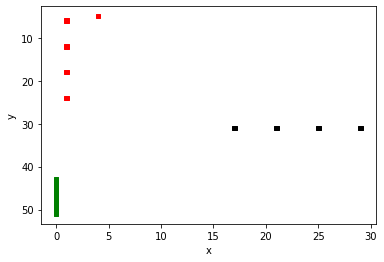

In [78]:
tx_coord_frame.plot.scatter(
    x="x", y="y", c=tx_coord_frame["cluster"].map(colors), marker="s"
)

plt.ylim(max(plt.ylim()), min(plt.ylim()))

### Treatments acknowledged by the Sample Meatadata Template

In [79]:
# template_treatments = template_menu_terms.loc[
#     ymin:ymax, xmin : (xmin + additional_columns)
# ]
# template_treatments

In [80]:
template_treatments = get_data_from_extended_cluster_coords(
    template_menu_terms, tx_coord_frame, tx_largest_index, additional_columns=3
)

template_treatments

,0,1,2,3
43,treatment,treatment-chemical administration/addition,chem_administration,{termLabel} {[termID]}; {timestamp}
44,treatment,treatment- watering regimen/schedule,watering_regm,{float} {unit};{Rn/start_time/end_time/duration}
45,treatment,treatment-air temperature regimen,air_temp_regm,{float} {unit};{Rn/start_time/end_time/duration}
46,treatment,treatment-gas evironment/exposure,gaseous_environment,{text};{float} {unit};{Rn/start_time/end_time/...
47,treatment,treatment-isotope exposure/addition,isotope_exposure,{text}
48,treatment,treatment-climate environment,climate_environment,{text};{Rn/start_time/end_time/duration}
49,treatment,treatment-humidity regimen/adition,humidity_regm,{float} {unit};{Rn/start_time/end_time/duration}
50,treatment,treatment-light regimen,light_regm,{text};{float} {unit};{float} {unit}
51,treatment,treatment-biotic regimen/addition,biotic_regm,{text}


In [81]:
# biosample_slots = nmdc_schema_resolved.classes["biosample"].slots
# biosample_slots.sort()
# biosample_slots

# these are all un-domained slots from mixs.yaml?

mixs_schema_resolved = SchemaLoader("../../nmdc-schema/src/schema/mixs.yaml").resolve()
# maybe we could/should limit these to subslots of attribute?
# isotope_exposure?

mixs_slots = list(mixs_schema_resolved.slots.keys())
mixs_slots.sort()

# print(len(mixs_slots))

# bmt get descendants gets ~ 614. Not worth importing?
# mixs_slots

Unrecognized prefix: UniProtKB
Unrecognized prefix: gtpo


In [82]:
set(template_treatments[2]) - set(mixs_slots)

{'isotope_exposure'}

In [83]:
# no transformation required, except that isotope_exposure is. not a defined slot
# ID column should be re-written as id

treatment_frame = treatment_frame.rename(columns={"ID": "id"})

treatment_frame

,id,isotope_exposure,watering_regm,chem_administration,air_temp_regm
3,UUID:472894-473947-847398,NaN,NaN,NaN,NaN
4,UUID:684267-410686-971057,13C Glucose,NaN,1000µg of C (glucose)/g soil,NaN
5,UUID:472894-473947-847396,NaN,75% water holding capacity; moisture maintaine...,1000µg of C (glucose)/g soil,NaN
6,UUID:516394-970067-847398,NaN,NaN,NaN,35C
7,UUID:472894-473947-642384,NaN,NaN,NaN,NaN


In [84]:
treatment_row_list = treatment_frame.to_dict("records")
treatment_row_list

[{'id': 'UUID:472894-473947-847398',
  'isotope_exposure': nan,
  'watering_regm': nan,
  'chem_administration': nan,
  'air_temp_regm': nan},
 {'id': 'UUID:684267-410686-971057',
  'isotope_exposure': '13C Glucose',
  'watering_regm': nan,
  'chem_administration': '1000µg of C (glucose)/g soil',
  'air_temp_regm': nan},
 {'id': 'UUID:472894-473947-847396',
  'isotope_exposure': nan,
  'watering_regm': '75% water holding capacity; moisture maintained every 3 days',
  'chem_administration': '1000µg of C (glucose)/g soil',
  'air_temp_regm': nan},
 {'id': 'UUID:516394-970067-847398',
  'isotope_exposure': nan,
  'watering_regm': nan,
  'chem_administration': nan,
  'air_temp_regm': '35C'},
 {'id': 'UUID:472894-473947-642384',
  'isotope_exposure': nan,
  'watering_regm': nan,
  'chem_administration': nan,
  'air_temp_regm': nan}]

In [85]:
cumulative_json_merge = merge_j_on_index(cumulative_json_merge, treatment_row_list)

In [86]:
# pprint(cumulative_json_merge)

#### `samp_collect_device`

range = (optionally language-typed) TextValue

No mongodb hits


In [87]:
scd_coord_frame = get_optics_coord_frame(template_menu_terms, "samp_collect_device")

In [88]:
scd_cluster_sizes = scd_coord_frame["cluster"].value_counts()
# scd_cluster_sizes

scd_largest_index = scd_cluster_sizes.index[0]
# scd_largest_index

In [89]:
# scd_coord_frame

In [90]:
# scd_coord_frame.plot.scatter(
#     x="x", y="y", c=scd_coord_frame["cluster"].map(colors), marker="s"
# )

# plt.ylim(max(plt.ylim()), min(plt.ylim()))

In [91]:
# scd_largest_index

In [92]:
template_scds = get_data_from_extended_cluster_coords(
    template_menu_terms, scd_coord_frame, scd_largest_index, additional_columns=3
)

template_scds

,0,1,2,3
37,samp_collect_device,sample collection device-shovel,shovel,{text}
38,samp_collect_device,sample collection device-slide hammer corer,slide_hammer_core,{text}
39,samp_collect_device,sample collection device- deep corer,deep_corer,{text}
40,samp_collect_device,sample collection device-russian corer,russian_corer,{text}
41,samp_collect_device,sample collection device-sipper,sipper,{text}
42,samp_collect_device,sample collection device-other,other-samp_collect_device,{text}


These are not properties, classes or enums in the NMDC or MIxS schemas

```YAML
  samp_collect_device:
    aliases:
      - sample collection device or method
    description: >-
       The method or device employed for collecting the sample
    multivalued: false
    is_a: attribute
    range: text value  ## syntax: {text}
    mappings:
      - mixs:samp_collect_device
    in_subset:
      - nucleic acid sequence source
```

newer canonical mixs: https://github.com/cmungall/mixs-source

#### template's `size_fract` = schema's `size_frac`

For domain and range, NMDC schema says `None →` _OPT_ `QuantityValue`

mongodb query `{ "size_frac": { $exists: true }}` against the `biosample_set` collection returns 0 documents

for reference, `{ "depth": { $exists: true }}` **does** return hits

The following columns are also allowed? by the template for water package samples

```
size_frac_low	size-fraction lower threshold	{float} {unit}
size_frac_up	size-fraction upper threshold	{float} {unit}
```

In [101]:
sf_coord_frame = get_optics_coord_frame(template_menu_terms, "size_fract")
sf_cluster_sizes = sf_coord_frame["cluster"].value_counts()
sf_largest_index = sf_cluster_sizes.index[0]

In [95]:
# sf_coord_frame.plot.scatter(
#     x="x", y="y", c=sf_coord_frame["cluster"].map(colors), marker="s"
# )

# plt.ylim(max(plt.ylim()), min(plt.ylim()))

Looks like we should manually use cluster 1 here, even though 0 would be reported as the first largest


In [96]:
template_sfs = get_data_from_extended_cluster_coords(
    template_menu_terms, sf_coord_frame, 1, additional_columns=3
)

template_sfs

,0,1,2,3
52,size_fract,size fraction-filter size,filter_size,{value}{units}
53,size_fract,size fraction-filter type,filter_type,{text}
54,size_fract,size fraction-sieve size,sieving,{value}{units}


These are not properties, classes or enums in the NMDC or MIxS schemas

```YAML
  size_frac:
    aliases:
      - size fraction selected
    description: >-
       Filtering pore size used in sample preparation
    multivalued: false
    is_a: attribute
    range: quantity value  ## syntax: {float}-{float} {unit}
    pattern: "\\d+[.\\d+]\\-\\d+[.\\d+] \\S+"
    string_serialization: "{float}-{float} {unit}"
    mappings:
      - mixs:size_frac
    in_subset:
      - nucleic acid sequence source
```

**What are the semantics here? Range = quantity value. Can specify one numeric and one unity, but won't be able to capture filter_type pr distinguish between filter_size or sieving.**

## Interim reshaped study data

Not complete, encoded or validated 

In [97]:
proj_nmdc = remove_nans_from_dict(proj_nmdc)
pprint(proj_nmdc)

{'doi': {'has raw value': 'https://doi.org/10.25585/1487765'},
 'id': '5c2b5eff69b8453babd69f85b379ea40',
 'name': '"Soil microbial response to elevated temperatures and increased '
         'carbon availability"',
 'principal_investigator': {'has raw value': 'Montana Smith',
                            'orcid': '0000-0002-8683-0050'},
 'publications': ['https://doi.org/10.1016/j.soilbio.2019.107561',
                  'Keiser, Ashley D., et al. "Peatland microbial community '
                  'response to altered climate tempered by nutrient '
                  'availability." Soil Biology and Biochemistry 137 (2019): '
                  '107561.'],
 'type': 'Study',
 'websites': ['https://microbiomedata.org/',
              'https://github.com/microbiomedata']}


In [98]:
proj_json = json.dumps(proj_nmdc, indent=4, sort_keys=False, default=str)
print(proj_json)

{
    "id": "5c2b5eff69b8453babd69f85b379ea40",
    "name": "\"Soil microbial response to elevated temperatures and increased carbon availability\"",
    "principal_investigator": {
        "has raw value": "Montana Smith",
        "orcid": "0000-0002-8683-0050"
    },
    "type": "Study",
    "websites": [
        "https://microbiomedata.org/",
        "https://github.com/microbiomedata"
    ],
    "publications": [
        "https://doi.org/10.1016/j.soilbio.2019.107561",
        "Keiser, Ashley D., et al. \"Peatland microbial community response to altered climate tempered by nutrient availability.\" Soil Biology and Biochemistry 137 (2019): 107561."
    ],
    "doi": {
        "has raw value": "https://doi.org/10.25585/1487765"
    }
}


## Interim reshaped sample data


In [99]:
pprint(cumulative_json_merge)

[{'ID': 'UUID:472894-473947-847398',
  'collection_date': '2020-05-21T12:00:00',
  'depth': {'has_raw_value': '0-1', 'has_unit': 'cm'},
  'elev': {'has_raw_value': 500, 'has_unit': 'm'},
  'env_broad_scale': 'arid biome',
  'env_local_scale': 'agricultural field',
  'env_medium': 'agricultural soil',
  'env_package': 'plant_associated',
  'geo_loc_name': 'USA; Prosser, Washington; Washington State '
                  'University-Irrigated Agriculture Research and Extension '
                  'Center',
  'gold_path_field': '5424:Environmental:Terrestrial:Soil:Bulk '
                     'soil:Agricultural land',
  'growth_facil': 'field',
  'id': 'UUID:472894-473947-847398',
  'investigation_type': 'genome|metabolome',
  'lat_lon': '46.251709, -119.728663',
  'name': 'P4_-0-10_4C',
  'ncbi_taxonomy_name': 'soil metagenome',
  'part_of': '5c2b5eff69b8453babd69f85b379ea40',
  'samp_mat_process': 'snap freeze in liquid N',
  'samp_store_temp': '4 degree Celsius',
  'store_cond': 'fresh',


In [100]:
cumulative_json_merge_json = json.dumps(
    cumulative_json_merge, indent=4, sort_keys=False, default=str
)

print(cumulative_json_merge_json)

[
    {
        "id": "UUID:472894-473947-847398",
        "name": "P4_-0-10_4C",
        "env_package": "plant_associated",
        "investigation_type": "genome|metabolome",
        "type": "Biosample",
        "part_of": "5c2b5eff69b8453babd69f85b379ea40",
        "growth_facil": "field",
        "geo_loc_name": "USA; Prosser, Washington; Washington State University-Irrigated Agriculture Research and Extension Center",
        "samp_mat_process": "snap freeze in liquid N",
        "store_cond": "fresh",
        "samp_store_temp": "4 degree Celsius",
        "env_broad_scale": "arid biome",
        "env_local_scale": "agricultural field",
        "env_medium": "agricultural soil",
        "lat_lon": "46.251709, -119.728663",
        "gold_path_field": "5424:Environmental:Terrestrial:Soil:Bulk soil:Agricultural land",
        "collection_date": "2020-05-21T12:00:00",
        "ncbi_taxonomy_name": "soil metagenome",
        "ID": "UUID:472894-473947-847398",
        "elev": {
         